In [23]:
from openai import OpenAI
import pandas as pd
import os
import json
from dotenv import load_dotenv
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# Load the API key from your .env
load_dotenv(dotenv_path=".env")  # You can give it the path explicitly
# Define api_key first
api_key = os.getenv("OPENAI_API_KEY")

https://www.kaggle.com/datasets/nair26/predictive-maintenance-of-machines/data

In [24]:
print("Loaded API key:", os.getenv("OPENAI_API_KEY")[:8] + "..." if os.getenv("OPENAI_API_KEY") else "❌ Not loaded")

Loaded API key: sk-proj-...


In [25]:

# Load the CSV file
df = pd.read_csv('Data/maintenance.csv')

# Display the first few rows of the DataFrame
df.sample(10)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Vibration Levels,Operational Hours,Failure Type
39,40,L47219,L,298.8,309.1,1350,52.5,32.309677,28.35,No Failure
344,345,M15204,M,297.5,308.2,2448,13.8,33.000000,110.37,No Failure
257,258,L47437,L,298.0,308.0,1615,29.5,25.273387,79.53,No Failure
248,249,L47428,L,298.0,308.3,1362,56.8,27.806452,76.34,No Failure
105,106,L47285,L,298.8,308.7,1591,31.1,35.000000,25.64,No Failure
267,268,L47447,L,297.9,308.0,1954,21.1,35.000000,83.07,Tool Wear Failure
131,132,L47311,L,298.8,308.4,1737,27.7,42.000000,34.85,No Failure
147,148,L47327,L,298.4,308.4,1515,40.1,54.000000,40.53,No Failure
71,72,L47251,L,298.9,309.1,1452,45.5,44.000000,30.99,No Failure
293,294,H29707,H,298.1,308.5,1392,44.8,42.000000,92.29,No Failure


Cleaning the data

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      500 non-null    int64  
 1   Product ID               500 non-null    object 
 2   Type                     500 non-null    object 
 3   Air temperature [K]      500 non-null    float64
 4   Process temperature [K]  500 non-null    float64
 5   Rotational speed [rpm]   500 non-null    int64  
 6   Torque [Nm]              500 non-null    float64
 7   Vibration Levels         500 non-null    float64
 8   Operational Hours        500 non-null    float64
 9   Failure Type             500 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 39.2+ KB


In [27]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Vibration Levels           0
Operational Hours          0
Failure Type               0
dtype: int64

In [28]:
df.duplicated().sum()

0

In [29]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Vibration Levels           float64
Operational Hours          float64
Failure Type                object
dtype: object

In [30]:
# Removes any leading/trailing whitespace from column names to ensure consistent access
df.columns = df.columns.str.strip()


In [31]:
print(df.columns.tolist())


['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Vibration Levels', 'Operational Hours', 'Failure Type']


In [32]:
# Training dataset
df_train = df.copy()
df_train['Failure Binary'] = df_train['Failure Type'].apply(lambda x: 0 if x == 'No Failure' else 1)
df_train = df_train.drop(['Failure Type', 'UDI', 'Product ID'], axis=1)

df_train.sample(10)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Vibration Levels,Operational Hours,Failure Binary
273,L,298.1,308.0,1426,46.0,45.000000,85.20,0
276,M,298.0,307.9,1750,26.6,23.000000,86.26,0
460,H,297.3,308.6,1431,42.0,35.000000,151.50,0
54,L,298.7,309.0,1691,30.1,28.087903,14.00,0
361,L,297.5,308.3,1596,36.8,36.000000,116.40,1
443,H,297.4,308.5,1469,45.1,27.243548,145.47,1
58,M,298.8,309.0,1661,29.5,26.962097,36.00,0
90,L,298.9,308.9,1753,25.8,23.000000,19.00,0
168,L,298.4,308.3,1433,62.3,36.000000,47.97,1
332,M,297.6,308.3,1538,40.2,23.000000,106.12,0


In [33]:
#Here we are transforming "Sex" columns which has values Male and Female, into 1 and 0 respectively so that the algorithm can understand easily.
le = LabelEncoder()
df_train["Type"] = le.fit_transform(df_train["Type"])
df_train.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Vibration Levels,Operational Hours,Failure Binary
0,2,298.1,308.6,1551,42.8,42.0,20.0,0
1,1,298.2,308.7,1408,46.3,52.0,21.0,0
2,1,298.1,308.5,1498,49.4,44.0,18.0,0
3,1,298.2,308.6,1433,39.5,52.0,10.0,0
4,1,298.2,308.7,1408,40.0,44.0,10.0,0


In [34]:
df_custom= df_train.copy()

In [35]:
X = df_train.drop('Failure Binary', axis=1)
Y = df_train['Failure Binary']
print(X.shape,Y.shape)
print(type(X))

(500, 7) (500,)
<class 'pandas.core.frame.DataFrame'>


In [36]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from sklearn.utils import resample

# --- 1. Entropy Function ---
def entropy(y):
    counts = np.bincount(y)
    probs = counts / len(y)
    return -np.sum([p * np.log2(p + 1e-9) for p in probs if p > 0])

# --- 2. Best Split Finder ---
def best_split(X, y, features):
    best_gain = 0
    best_feat, best_thresh = None, None
    base_entropy = entropy(y)
    
    for feat in features:
        thresholds = np.unique(X[feat])
        for t in thresholds:
            left = y[X[feat] <= t]
            right = y[X[feat] > t]
            if len(left) == 0 or len(right) == 0:
                continue
            gain = base_entropy - (len(left)/len(y))*entropy(left) - (len(right)/len(y))*entropy(right)
            if gain > best_gain:
                best_gain = gain
                best_feat, best_thresh = feat, t
    return best_feat, best_thresh, best_gain

# --- 3. Custom Decision Tree ---
class CustomTree:
    def __init__(self, depth=0, max_depth=5, min_samples=5):
        self.depth = depth
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.left = None
        self.right = None
        self.feature = None
        self.threshold = None
        self.prediction = None
        self.feature_importance = {}

    def fit(self, X, y):
        if len(set(y)) == 1 or self.depth >= self.max_depth or len(y) < self.min_samples:
            self.prediction = Counter(y).most_common(1)[0][0]
            return

        feat, thresh, gain = best_split(X, y, X.columns)
        if feat is None:
            self.prediction = Counter(y).most_common(1)[0][0]
            return

        self.feature = feat
        self.threshold = thresh
        self.feature_importance[feat] = self.feature_importance.get(feat, 0) + gain

        mask = X[feat] <= thresh

        self.left = CustomTree(self.depth + 1, self.max_depth, self.min_samples)
        self.left.fit(X[mask], y[mask])

        self.right = CustomTree(self.depth + 1, self.max_depth, self.min_samples)
        self.right.fit(X[~mask], y[~mask])

        for tree in [self.left, self.right]:
            for f, imp in tree.feature_importance.items():
                self.feature_importance[f] = self.feature_importance.get(f, 0) + imp

    def predict_row(self, row):
        if self.prediction is not None:
            return self.prediction
        if row[self.feature] <= self.threshold:
            return self.left.predict_row(row)
        else:
            return self.right.predict_row(row)

    def predict(self, X):
        return X.apply(self.predict_row, axis=1)

# --- 4. Preprocessing: Balance Dataset ---
# Replace `df_custom` with your actual DataFrame
df_majority = df_custom[df_custom['Failure Binary'] == 0]
df_minority = df_custom[df_custom['Failure Binary'] == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority), 
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42)

X = df_balanced.drop(columns=['Failure Binary'])
y = df_balanced['Failure Binary']

# Optional: One-hot encode categorical variables like 'Type'
if 'Type' in X.columns:
    X = pd.get_dummies(X, columns=['Type'])

# --- 5. Train/Test Split ---
split = int(0.7 * len(X))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# --- 6. Train & Evaluate Single Decision Tree ---
tree = CustomTree(max_depth=5)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Failure", "Failure"]))

print("\nFeature Importances:")
importances = tree.feature_importance
total = sum(importances.values())
for feat, imp in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    norm_imp = imp / total if total else 0
    print(f"{feat}: {norm_imp:.4f}")


Confusion Matrix:
[[ 83  46]
 [  0 152]]

Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      0.64      0.78       129
     Failure       0.77      1.00      0.87       152

    accuracy                           0.84       281
   macro avg       0.88      0.82      0.83       281
weighted avg       0.87      0.84      0.83       281


Feature Importances:
Process temperature [K]: 0.4646
Operational Hours: 0.2518
Rotational speed [rpm]: 0.1659
Air temperature [K]: 0.0921
Vibration Levels: 0.0255


In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import random

# 1. Entropy calculation
def entropy(y):
    counts = np.bincount(y)
    probs = counts / len(y)
    return -np.sum([p * np.log2(p + 1e-9) for p in probs if p > 0])

# 2. Split finder
def best_split(X, y, features):
    best_gain = 0
    best_feat, best_thresh = None, None
    base_entropy = entropy(y)
    
    for feat in features:
        thresholds = np.unique(X[feat])
        for t in thresholds:
            left = y[X[feat] <= t]
            right = y[X[feat] > t]
            if len(left) == 0 or len(right) == 0:
                continue
            gain = base_entropy - (len(left)/len(y))*entropy(left) - (len(right)/len(y))*entropy(right)
            if gain > best_gain:
                best_gain = gain
                best_feat, best_thresh = feat, t
    return best_feat, best_thresh, best_gain

# 3. Custom Decision Tree Node
class CustomTree:
    def __init__(self, depth=0, max_depth=5, min_samples=5):
        self.depth = depth
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.left = None
        self.right = None
        self.feature = None
        self.threshold = None
        self.prediction = None
        self.feature_importance = {}  # <-- track feature importance here

    def fit(self, X, y):
        if len(set(y)) == 1 or self.depth >= self.max_depth or len(y) < self.min_samples:
            self.prediction = Counter(y).most_common(1)[0][0]
            return

        feat, thresh, gain = best_split(X, y, X.columns)
        if feat is None:
            self.prediction = Counter(y).most_common(1)[0][0]
            return

        self.feature = feat
        self.threshold = thresh
        
        # Accumulate feature importance by information gain
        self.feature_importance[feat] = self.feature_importance.get(feat, 0) + gain

        mask = X[feat] <= thresh

        self.left = CustomTree(self.depth + 1, self.max_depth, self.min_samples)
        self.left.fit(X[mask], y[mask])

        self.right = CustomTree(self.depth + 1, self.max_depth, self.min_samples)
        self.right.fit(X[~mask], y[~mask])

        # Merge children's feature importance into this node
        for tree in [self.left, self.right]:
            for f, imp in tree.feature_importance.items():
                self.feature_importance[f] = self.feature_importance.get(f, 0) + imp

    def predict_row(self, row):
        if self.prediction is not None:
            return self.prediction
        if row[self.feature] <= self.threshold:
            return self.left.predict_row(row)
        else:
            return self.right.predict_row(row)

    def predict(self, X):
        return X.apply(self.predict_row, axis=1)

# 4. Mini Random Forest
class RandomForestLite:
    def __init__(self, n_trees=5, sample_size=0.8, max_depth=5):
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            idxs = np.random.choice(len(X), int(self.sample_size * len(X)), replace=True)
            X_sample = X.iloc[idxs]
            y_sample = y.iloc[idxs]
            tree = CustomTree(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return [Counter(tree_preds[:, i]).most_common(1)[0][0] for i in range(X.shape[0])]

    def feature_importances(self):
        total_importance = {}
        for tree in self.trees:
            for feat, imp in tree.feature_importance.items():
                total_importance[feat] = total_importance.get(feat, 0) + imp
        total = sum(total_importance.values())
        if total == 0:
            return {feat: 0 for feat in self.trees[0].feature_importance.keys()}
        return {feat: imp / total for feat, imp in total_importance.items()}

# 5. Assume df_custom exists with 'Failure Binary' column
from sklearn.utils import resample

df_majority = df_custom[df_custom['Failure Binary'] == 0]
df_minority = df_custom[df_custom['Failure Binary'] == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority), 
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42)

X = df_balanced.drop(columns=['Failure Binary'])
y = df_balanced['Failure Binary']

# One-hot encode 'Type' if it exists
if 'Type' in X.columns:
    X = pd.get_dummies(X, columns=['Type'])

# 6. Train/test split
split = int(0.7 * len(X))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 7. Train & Evaluate
rf_lite = RandomForestLite(n_trees=5, max_depth=5)
rf_lite.fit(X_train, y_train)
y_pred = rf_lite.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Failure", "Failure"]))

print("\nFeature Importances:")
importances = rf_lite.feature_importances()
for feat, imp in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"{feat}: {imp:.4f}")


Confusion Matrix:
[[102  27]
 [  5 147]]

Classification Report:
              precision    recall  f1-score   support

  No Failure       0.95      0.79      0.86       129
     Failure       0.84      0.97      0.90       152

    accuracy                           0.89       281
   macro avg       0.90      0.88      0.88       281
weighted avg       0.89      0.89      0.88       281


Feature Importances:
Operational Hours: 0.2889
Air temperature [K]: 0.2752
Process temperature [K]: 0.2554
Vibration Levels: 0.0824
Rotational speed [rpm]: 0.0633
Type_0: 0.0250
Torque [Nm]: 0.0098


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# --- 1. Preprocessing: Balance the dataset ---
# Replace df_custom with your actual DataFrame
df_majority = df_custom[df_custom['Failure Binary'] == 0]
df_minority = df_custom[df_custom['Failure Binary'] == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority), 
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42)

X = df_balanced.drop(columns=['Failure Binary'])
y = df_balanced['Failure Binary']

# Optional: One-hot encode 'Type' if it exists
if 'Type' in X.columns:
    X = pd.get_dummies(X, columns=['Type'])

# --- 2. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- 3. Train Gradient Boosted Tree ---
gbdt = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=42
)
gbdt.fit(X_train, y_train)

# --- 4. Evaluate Model ---
y_pred = gbdt.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Failure", "Failure"]))

# --- 5. Feature Importances ---
print("\nFeature Importances:")
importances = gbdt.feature_importances_
for feat, imp in sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feat}: {imp:.4f}")



Confusion Matrix:
[[143  10]
 [  0 128]]

Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      0.93      0.97       153
     Failure       0.93      1.00      0.96       128

    accuracy                           0.96       281
   macro avg       0.96      0.97      0.96       281
weighted avg       0.97      0.96      0.96       281


Feature Importances:
Operational Hours: 0.5318
Air temperature [K]: 0.1368
Rotational speed [rpm]: 0.1016
Process temperature [K]: 0.0928
Torque [Nm]: 0.0651
Vibration Levels: 0.0637
Type_0: 0.0056
Type_2: 0.0025
Type_1: 0.0000


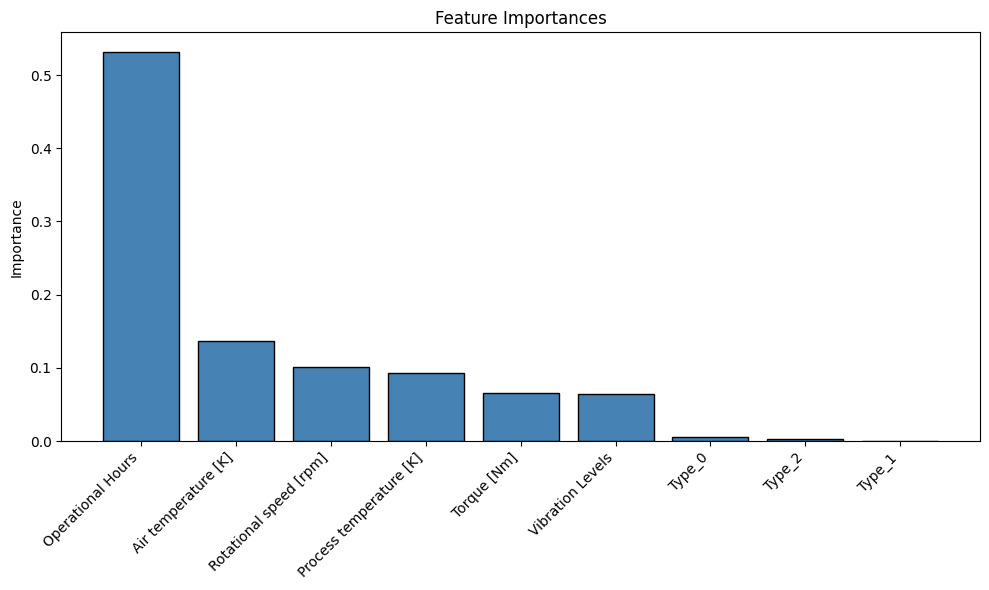

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have:
# - X (feature DataFrame)
# - gbdt (trained GradientBoostingClassifier)

importances = gbdt.feature_importances_
features = X.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_features = features[indices]
sorted_importances = importances[indices]

plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(len(sorted_importances)), sorted_importances, color='steelblue', edgecolor='black')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=45, ha='right')
plt.ylabel("Importance")
plt.tight_layout()
plt.show()



In [22]:
gbdt_custom = CustomGBDT(n_estimators=10, learning_rate=0.1, max_depth=3)
gbdt_custom.fit(X_train, y_train)
y_pred = gbdt_custom.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Failure", "Failure"]))


NameError: name 'CustomGBDT' is not defined